# Deep Neural Networks 
## Lecture 03

## Implementation of Perceptron


## 1. Import Statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
 
%matplotlib inline

## 2. Setup Global Parameters

In [2]:
###----------------
### Some parameters
###----------------

# Directory locations
inpDir = '../../input'
outDir = '../output'

RANDOM_STATE = 23 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 10001  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## 3. Generate Data Set
<div style="font-family: Arial; font-size:1.2em;color:white;">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [3]:
X,y = datasets.make_moons(n_samples=N_SAMPLES,shuffle=True,noise=NOISE,random_state=RANDOM_STATE)
X.shape,y.shape

((1000, 2), (1000,))

## 4. Visualization
<p style="font-family: Arial; font-size:1.2em;color:white;">
DataFrames are easier to visualize
</p>

In [4]:
data_df=pd.DataFrame(X,columns=['A','B'])
data_df['target']=y
data_df.head()

,A,B,target
0,-0.029033,0.253046,1
1,1.288946,-0.079415,1
2,0.155971,0.879749,0
3,0.032590,0.487471,1
4,2.285296,0.462694,1


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [6]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
A,1000.0,0.491922,0.889694,-1.434693,-0.109430,0.460027,1.094022,2.643058
B,1000.0,0.248078,0.540661,-0.919273,-0.215778,0.259477,0.687156,1.443934
target,1000.0,0.500000,0.500250,0.000000,0.000000,0.500000,1.000000,1.000000


In [7]:
data_df['target'].unique()

array([1, 0])

### 4.1 Different ways of plotting data

<Axes: xlabel='A', ylabel='B'>

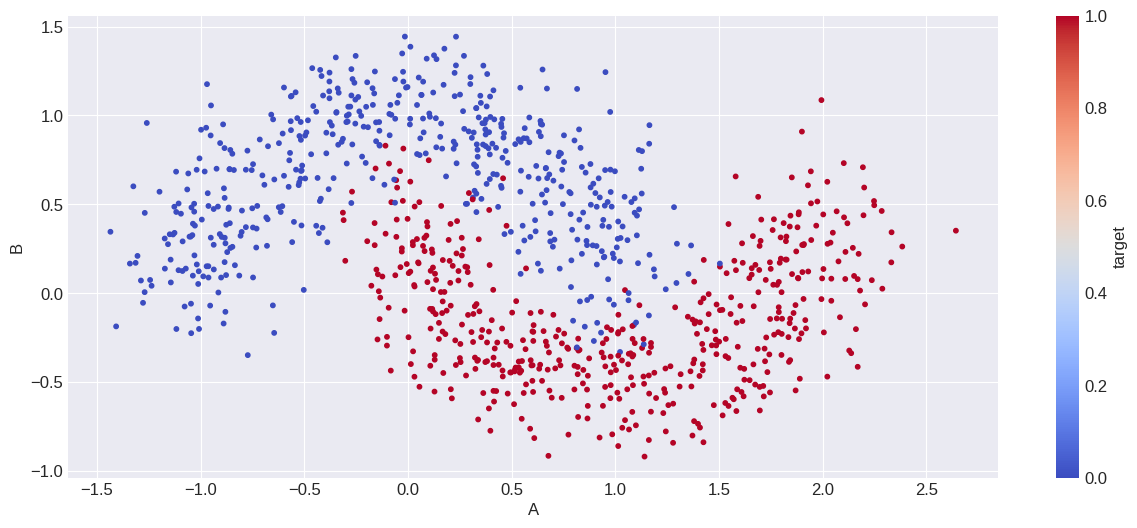

In [8]:
data_df.plot.scatter('A','B',s=10,c='target',cmap=CMAP)

<Axes: xlabel='target'>

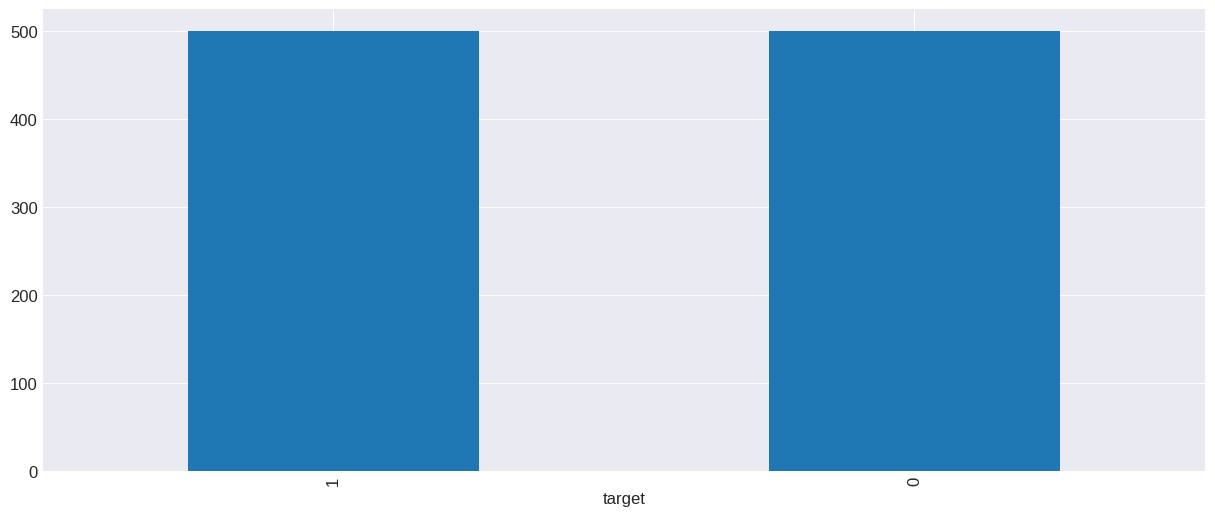

In [9]:
data_df['target'].value_counts().plot(kind='bar')

/home/dai/anaconda3/envs/DNN/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dai/anaconda3/envs/DNN/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dai/anaconda3/envs/DNN/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dai/anaconda3/envs/DNN/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstan

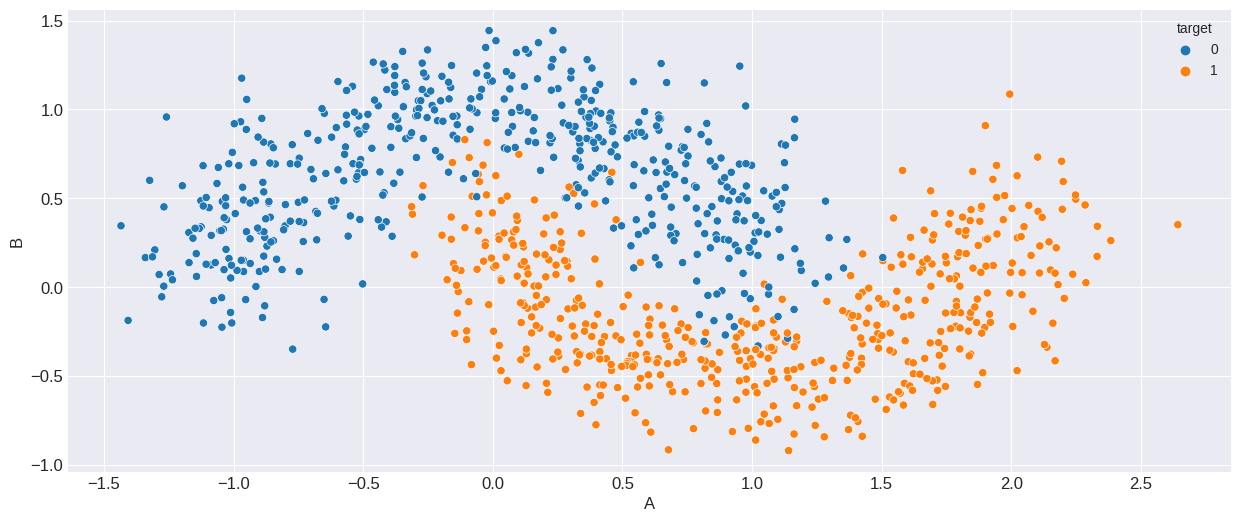

In [10]:
sns.scatterplot(x='A',y='B',data=data_df,hue='target');

<div style="font-family: Arial; font-size:1.2em;">
    We will keep 10%, i.e. 100 records for testing and remaining records will be used in training. Note that the data is already random.
</div>

In [11]:
y = pd.get_dummies(y).to_numpy()
y.shape

(1000, 2)

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=TEST_SIZE,
                                                 stratify=y,random_state=RANDOM_STATE)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((800, 2), (200, 2), (800, 2), (200, 2))

# Over to Perceptron

<div style="font-family: Arial; font-size:1.1em;">

Our output is binary. To keep the code in line with what we discussed in the lecture, we will simply output 1 for positive values of 'z' and zero for negative values.
</div>

<img src="images/dnn_nb_s03_fig1.png" width='350' align = 'left'>


$$
\begin{aligned}
z & = 1.0 \circ w_0 + x_1 \circ w_1 + x_2 \circ w_2 \\
\mathrm{or}\\
z & = X\circ W \\
\end{aligned}
$$
<br/>


$$
\begin{equation*}
    \hat{y} = \begin{cases}
      1.0, & \text{for z>=0}\  \\
      0.0, & \text{for z<0}\
    \end{cases}
\end{equation*}
$$

<div style="font-family: Arial; font-size:1em;">
<p>
As we know that adjustments in the weights are (a-$\hat{y}$). We don't want to adjust by full value. It makes convergence easier if we adjust by a small fraction. </p>
    <p><b>Why?</b> We would know better all through this module. We will circle back to learning_rate after some sessions.
<p>Let's assume that adjusting weights by $\alpha$ * ( a - $\hat{y}$ ) makes better sense. </p>
<p>
    <strong>Note:</strong> Take learning_rate ($\alpha$) as some constant.
</p>
</div>

### Softmax Function

In [13]:
def fn_softmax(z):
    exp_scores = np.exp(z)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

In [14]:
fn_softmax(np.array([[-np.inf, 0, np.inf],[-5,2,5]])).sum(axis = 1)

/tmp/ipykernel_90398/1001682264.py:3: RuntimeWarning: invalid value encountered in divide
  return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


array([nan,  1.])

### Tanh Activation Function

In [15]:
def fn_actv(z):
    return np.tanh(z)
def fn_actv_prime(a):
    return 1- np.tanh(a)**2

In [16]:
fn_actv(np.array([[-1,0,1],[-np.inf,0,np.inf]]))

array([[-0.76159416,  0.        ,  0.76159416],
       [-1.        ,  0.        ,  1.        ]])

In [17]:
np.tanh(0.5)

0.46211715726000974

In [18]:
fn_actv_prime(0.5)

0.7864477329659274

## 5. Prediction

In [19]:
# a function to make prediction
def predict(model,X):
    W1,b1,W2,b2,W3,b3,W4,b4,W5,b5 = model['W1'],model['b1'],model['W2'],model['b2'],model['W3'],model['b3'],model['W4'],model['b4'],model['W5'],model['b5']
    
    #### Forward Propagation
    ## Layer 1
    z1=X.dot(W1)+b1  #Aggregation Fn
    a1=fn_actv(z1)   #Activation Fn
        
    ## Layer 2
    z2=a1.dot(W2)+b2  #Aggregation Fn
    a2=fn_actv(z2)    #Activation Fn
        
    ## Layer 3
    z3 = a2.dot(W3) + b3
    a3 = fn_actv(z3)
        
    ## Layer 4
    z4 = a3.dot(W4) + b4
    a4 = fn_actv(z4)
        
    ## Layer 5
    z5 = a4.dot(W5) + b5
    a5 = fn_softmax(z5)
    
    return np.argmax(a5, axis = 1)


**Its advisable to test the function**

In [20]:
def calculate_loss(model,X,y):
    W1,b1,W2,b2,W3,b3,W4,b4,W5,b5 = model['W1'],model['b1'],model['W2'],model['b2'],model['W3'],model['b3'],model['W4'],model['b4'],model['W5'],model['b5']
    m=X.shape[0]
    #### Forward Propagation
    ## Layer 1
    z1=X.dot(W1)+b1  #Aggregation Fn
    a1=fn_actv(z1)   #Activation Fn
        
    ## Layer 2
    z2=a1.dot(W2)+b2  #Aggregation Fn
    a2=fn_actv(z2)    #Activation Fn
        
    ## Layer 3
    z3 = a2.dot(W3) + b3
    a3 = fn_actv(z3)
        
    ## Layer 4
    z4 = a3.dot(W4) + b4
    a4 = fn_actv(z4)
        
    ## Layer 5
    z5 = a4.dot(W5) + b5
    a5 = fn_softmax(z5)
    
    data_loss=-(y*np.log(a5)+(1-y)*np.log(1-a5)).sum()
    
    return 1./m * data_loss

<div style="font-family: Arial; font-size:1.2em;">
    <h3>Back-propagation - Estimate Perceptron weights </h3>
    $
\begin{aligned}
\partial{z}  & = a - y \\
\partial{b}  & = \partial{z} \\
\partial{w_1}  & = x_1 \circ \partial{z}\\
\partial{w_2}  & = x_2 \circ \partial{z}\\
\end{aligned}
$
    <hr>
      $
\begin{aligned}
b & = b -  \frac{1}{m} (\alpha \circ \partial{b}) \\
w_1  & = w_1 - \frac{1}{m}(\alpha \circ \partial{w_1} )\\
w_2  & = w_2 - \frac{1}{m}(\alpha \circ \partial{w_2} )\\
\end{aligned}
$
    </div>
    


 ## 6. Training

In [21]:
# function to train the model
def build_model(X,y,alpha=ALPHA,epochs=EPOCHS):
    
    W1 = np.random.rand(nn_input_dim,nn_hdim)/np.sqrt(nn_input_dim)
    W2 = np.random.rand(nn_hdim,nn_hdim2)/np.sqrt(nn_hdim)
    W3 = np.random.rand(nn_hdim2,nn_hdim3)/np.sqrt(nn_hdim2)
    W4 = np.random.rand(nn_hdim3,nn_hdim4)/np.sqrt(nn_hdim3)
    W5 = np.random.rand(nn_hdim4, nn_output_dim) / np.sqrt(nn_hdim4)

    b1 = np.zeros((1,nn_hdim))
    b2 = np.zeros((1,nn_hdim2))
    b3 = np.zeros((1,nn_hdim3))
    b4 = np.zeros((1,nn_hdim4))
    b5 = np.zeros((1, nn_output_dim))
    
    curr_loss=0
    loss,epoch=[],[]
    
    m=X.shape[0]
    
    for i in range(epochs):
        
        #### Forward Propagation
        
        ## Layer 1
        z1=X.dot(W1)+b1  #Aggregation Fn
        a1=fn_actv(z1)   #Activation Fn
        
        ## Layer 2
        z2=a1.dot(W2)+b2  #Aggregation Fn
        a2=fn_actv(z2)    #Activation Fn
        
        ## Layer 3
        z3 = a2.dot(W3) + b3
        a3 = fn_actv(z3)
        
        ## Layer 4
        z4 = a3.dot(W4) + b4
        a4 = fn_actv(z4)
        
        ## Layer 5
        z5 = a4.dot(W5) + b5
        a5 = fn_softmax(z5)

        #### Back Propagation
        dz5 = a5 - y
        
        ## Layer 5
        assert(z5.shape==dz5.shape),f'error z5 {z5.shape}/{dz5.shape}'
        dW5 = a4.T.dot(dz5)
        assert(W5.shape==dW5.shape),f'error w5 {W5.shape}/{dW5.shape}'
        db5 = np.sum(dz5, axis=0, keepdims=True)
        assert(b5.shape==db5.shape),f'error b5 {b5.shape}/{db5.shape}'
        da4 = dz5.dot(W5.T)
        
        ## Layer 4
        dz4 = da4 * fn_actv_prime(z4)
        assert(z4.shape==dz4.shape),f'error z4 {z4.shape}/{dz4.shape}'
        dW4 = a3.T.dot(dz4)
        assert(W4.shape==dW4.shape),f'error W4 {W4.shape}/{dW4.shape}'
        db4 = np.sum(dz4, axis=0, keepdims=True)
        assert(b4.shape==db4.shape),f'error b4 {b4.shape}/{db4.shape}'
        da3 = dz4.dot(W4.T)
        
        ## Layer 3
        dz3 = da3 * fn_actv_prime(z3)
        assert(z3.shape==dz3.shape),f'error z3 {z3.shape}/{dz3.shape}'
        dW3 = a2.T.dot(dz3)
        assert(W3.shape==dW3.shape),f'error W3 {W3.shape}/{dW3.shape}'
        db3 = np.sum(dz3, axis=0, keepdims=True)
        assert(b3.shape==db3.shape),f'error b3 {b3.shape}/{db3.shape}'
        da2 = dz3.dot(W3.T)
        
        ## Layer 2
        dz2 = da2 * fn_actv_prime(z2)
        assert(z2.shape==dz2.shape),f'error z2 {z2.shape}/{dz2.shape}'
        dW2 = a1.T.dot(dz2)
        assert(W2.shape==dW2.shape),f'error W2 {W2.shape}/{dW2.shape}'
        db2 = np.sum(dz2, axis=0, keepdims=True)
        assert(b2.shape==db2.shape),f'error b2 {b2.shape}/{db2.shape}'
        da1 = dz2.dot(W2.T)

        ## Layer 1
        dz1 = da1 * fn_actv_prime(z1)
        dW1 = X.T.dot(dz1)
        assert(W1.shape==dW1.shape),f'error W1 {W1.shape}/{dW1.shape}'
        db1 = np.sum(dz1, axis=0, keepdims=True)
        assert(b1.shape==db1.shape),f'error b1 {b1.shape}/{db1.shape}'
        
        # Gradient update
        W1 -= alpha * dW1 / m
        W2 -= alpha * dW2 / m
        W3 -= alpha * dW3 / m
        W4 -= alpha * dW4 / m
        W5 -= alpha * dW5 / m
        b1 -= alpha * db1 / m
        b2 -= alpha * db2 / m
        b3 -= alpha * db3 / m
        b4 -= alpha * db4 / m
        b5 -= alpha * db5 / m

        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3,
                 'W4': W4, 'b4': b4, 'W5': W5, 'b5': b5}
        
        if i % 100 == 0:
            curr_loss = calculate_loss(model, X, y)
            loss.append(curr_loss)
            epoch.append(i)
            print(f'epoch:{i}; current_loss={curr_loss:.4f}')

    
    hist['loss']=loss
    hist['epoch']=epoch

    return model

In [22]:
nn_input_dim = X_train.shape[1]
nn_hdim = 50
nn_hdim2 = 50
nn_hdim3 = 40
nn_hdim4 = 30
nn_output_dim = 2

hist = {}

In [23]:
#y_train = y_train.reshape(-1,1)

In [24]:
model = build_model(X_train,y_train)

epoch:0; current_loss=1.3701
epoch:100; current_loss=1.2946
epoch:200; current_loss=1.2217
epoch:300; current_loss=1.1601
epoch:400; current_loss=1.1178
epoch:500; current_loss=1.0451
epoch:600; current_loss=1.0182
epoch:700; current_loss=0.9952
epoch:800; current_loss=0.9655
epoch:900; current_loss=0.9352
epoch:1000; current_loss=0.8975
epoch:1100; current_loss=0.7917
epoch:1200; current_loss=0.7074
epoch:1300; current_loss=0.6486
epoch:1400; current_loss=0.6172
epoch:1500; current_loss=0.6009
epoch:1600; current_loss=0.5915
epoch:1700; current_loss=0.5848
epoch:1800; current_loss=0.5790
epoch:1900; current_loss=0.5720
epoch:2000; current_loss=0.5545
epoch:2100; current_loss=0.4839
epoch:2200; current_loss=0.3463
epoch:2300; current_loss=0.2245
epoch:2400; current_loss=0.1701
epoch:2500; current_loss=0.1750
epoch:2600; current_loss=0.1594
epoch:2700; current_loss=0.1509
epoch:2800; current_loss=0.1463
epoch:2900; current_loss=0.1434
epoch:3000; current_loss=0.1415
epoch:3100; current_

## 7. Predictions

### Train Set

In [25]:
y_pred = predict(model, X_train)
y_pred.shape

(800,)

In [26]:
print('Accuracy score on Train Data :', accuracy_score(np.argmax(y_train, axis = 1), y_pred))

Accuracy score on Train Data : 0.9725


In [27]:
print(classification_report(np.argmax(y_train,axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       400
           1       0.98      0.97      0.97       400

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



### Test Set

In [28]:
y_pred = predict(model, X_test)

print('Accuracy score on Test Data :', accuracy_score(np.argmax(y_test,axis=1), y_pred))

Accuracy score on Test Data : 0.945


In [29]:
print(classification_report(np.argmax(y_test,axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       100
           1       0.95      0.94      0.94       100

    accuracy                           0.94       200
   macro avg       0.95      0.94      0.94       200
weighted avg       0.95      0.94      0.94       200



In [44]:
cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
cm

array([[ 405,    0,    0,    0],
       [   0, 1094,   79,    0],
       [   0,   94, 1185,   89],
       [   0,    4,  152,  528]])

## Decision Boundary

In [30]:
def fn_plot_decision_boundary(pred_func,X_tr,y_tr,X_ts,y_ts):
    '''
        Attrib:
           pred_func : function based on predict method of the classifier
           X_tr : train feature matrix
           y_tr : train labels
           X_ts : test feature matrix
           y_ts : test labels
       Return:
           None
    '''
    
    # Set min and max values and give it some padding
    xMin, xMax = X_tr[:, 0].min() - .05, X_tr[:, 0].max() + .05
    yMin, yMax = X_tr[:, 1].min() - .05, X_tr[:, 1].max() + .05
    
    # grid size for mesh grid
    h = 0.01
    
    # Generate a grid of points with distance 'h' between them
    xx, yy = np.meshgrid(np.arange(xMin, xMax, h), np.arange(yMin, yMax, h))
    
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    
    # Make its shape same as that of xx 
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    ax = fig.add_axes(111)
    
    # Now we have Z value corresponding to each of the combination of xx and yy
    # Plot the contour and training examples
    ax.contourf(xx, yy, Z, cmap=CMAP) #, alpha = 0.8
    
    # Plotting scatter for train data
    ax.scatter(X_tr[:, 0], X_tr[:, 1], c=np.argmax(y_tr,axis=1),
                                  s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    
    
    # Plotting scatter for test data
    ax.scatter(X_ts[:, 0], X_ts[:, 1], c=np.argmax(y_ts,axis=1),
                                  s=150, marker = '*',edgecolor='k', cmap=plt.cm.inferno )

    
    

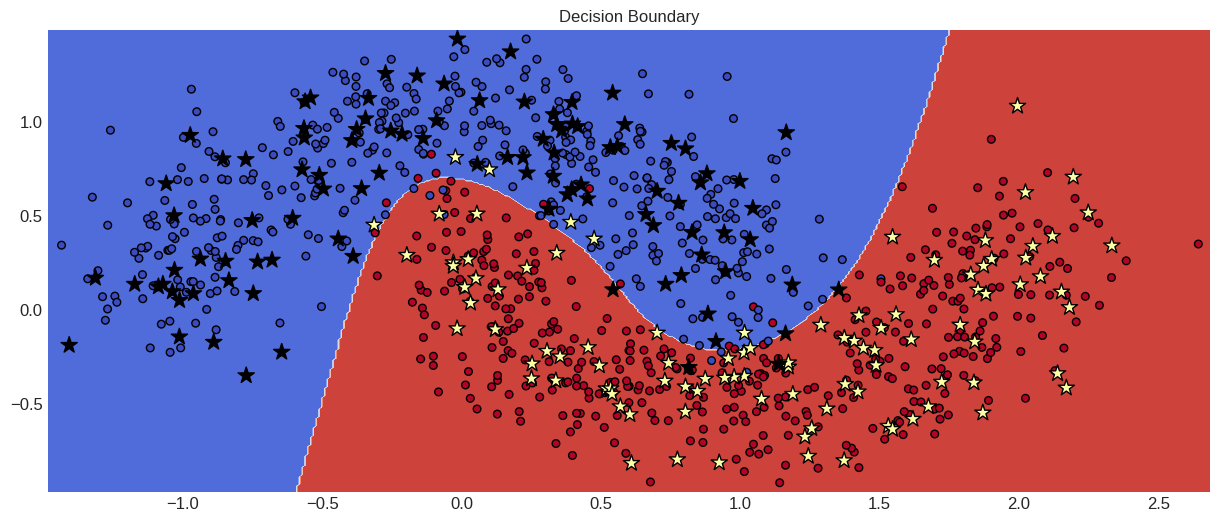

In [31]:
loss_df = pd.DataFrame(hist)

fn_plot_decision_boundary(lambda x: predict(model, x), X_train, y_train, X_test, y_test) # plot decision boundary for this plot

plt.title("Decision Boundary");

## Tracking
<div style="font-family: Arial; font-size:1.2em;color:black;">
Lets track the results across various implementations...

 |#|Implementation|Training Accuracy|Testing Accuracy|Remarks|
 |:-:|---|---|---|---|
 |1|Simple Perceptron|0.83111|0.89000||

## Notes:
<img src="images/dnn_nb_s03_fig1.png" width='350' align = 'left'>
<img src="images/dnn_nb_s03_fig2.png" width='350' align = 'right'>

## A note on Loss Function
<div style="font-family: Arial; font-size:1.2em;">
    <p>In logistic regression we are looking for if it is correct class or not. </p> 
    <p>For example, we want to know if there is a car in the picture or not. So the output is probability of a car in the picture.</p>
    <p><b>Mathematically speaking:</b></p>
    <p>$\hat{y} = p(y=1|x)$ i.e. given training sample $x$, we want to know probability of $y$ being 1.</p>
    <br>
    <p><b>Alternatively:</b></p>
    <p>If there is a car in the picture.  $\Rightarrow$  $y$ = 1 then $p(y|x)$ = $\hat{y}$.</p>
    <p>If there is <b>no</b> car in the picture.$\Rightarrow$ $y$ = 0 then $p(y|x)$ = 1 - $\hat{y}$.</p>
    <br>
    <p>We can summarize two equations as: $p(y|x)$ = $\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}$</p>
    <p>Above equation is $\hat{y}$ for y = 1 and (1 - $\hat{y}$) for y = 0.</p>
    <p>Taking log of above equation:</p>

$
\begin{aligned}
log [ p(y|x) ] & = log[\hat{y}^{y} * (1 - \hat{y}) ^{(1-y)}]\\
& = y * log(\hat{y}) + (1-y) * log(1 - \hat{y})\\
\end{aligned}
$
<p>Since we aim to minimize above function, add negative sign and our loss function becomes</p>

$
\begin{aligned}
L(\hat{y},y) =  -[y * log\hat{y} + (1-y) * log(1-\hat{y})]\\
\text{or}\\
L(a,y) =  - [ y * log ( a ) + ( 1 - y ) * log( 1 - a ) ]\\
\end{aligned}
$

|Case| y |Loss| a |-log(a)|-log(1-a)|
|:-: |:-:|:-: |:-:|  :-: |   :-:  |
| 1  | 0 | -log( 1 - a )| 0.000001 |13.8155|**1 e-6**|
| 2  | 0 | -log( 1 - a )| 0.999999 |1 e-6|**13.8155**|
| 3  | 1 | -log( a )| 0.000001 |**13.8155**|1 e-6|
| 4  | 1 | -log( a )| 0.999999 |**1 e-6**|13.8155|

</div>

<div style="font-family: Arial; font-size:1.2em;">
    <p>For binary classification the error = - $y * log(a)$</p>
    <p>We want to sum it up for all samples in the dataset. Hence:</p>

$
\begin{aligned}
p(\text{all ys | all rows of x}) & =  \Pi_{i=0}^m p(y|x)\\
log [ p(\text{all ys | all rows of x})] & =  log [ \Pi_{i=0}^m p(y|x) ]\\
& =  \sum_{i=0}^m log [ p(y|x) ] \\
& =  \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\text{Divide it by m to better scale the costs}\\
& = \frac{1}{m} * \sum_{i=0}^m [ y * log(\hat{y}) + (1-y) * log(1 - \hat{y}) ]\\
\end{aligned}
$

### Introducing $\mathrm{sigmoid}$ function for our binary output.
$$
\begin{aligned}
z & = x_1 . w_1 + x_2 . w_2 + b_1 \\
a & = \hat{y} = \sigma(z)\\
dz & = (a - y) \\
db & = dz\\
b & = b - \alpha . db\\
dw_1 & = x_1. dz\\
dw_2 & = x_2.dz\\
w_1 & = w_1 - \alpha . dw_1\\
w_2 & = w_1 - \alpha . dw_2\\
\end{aligned}
$$
### Sigmoid function
$$
\begin{align}
a &= \sigma(z)\\
&= \dfrac{1}{1 + e^{-z}}\\
\end{align}
$$
    <h3>Derivative of sigmoid function</h3>
$$
\begin{align}
\partial{a} &= \partial{(\sigma(z))}\\
&= \dfrac{\partial}{\partial{z}} \left[ \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{\partial}{\partial{z}} \left( 1 + \mathrm{e}^{-z} \right)^{-1} \\
&= -(1 + e^{-z})^{-2}(-e^{-z}) \\
&= \dfrac{e^{-z}}{\left(1 + e^{-z}\right)^2} \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{e^{-z}}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \dfrac{(1 + e^{-z}) - 1}{1 + e^{-z}}  \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ \dfrac{1 + e^{-z}}{1 + e^{-z}} - \dfrac{1}{1 + e^{-z}} \right] \\
&= \dfrac{1}{1 + e^{-z}\ } \circ \left[ 1 - \dfrac{1}{1 + e^{-z}} \right] \\
&= \sigma(z) \circ (1 - \sigma(z))\\
&= a \circ (1 - a)
\end{align}
$$
    </div>